# Brain Tumor Detector

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

In [2]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/Users/kristinaliu/anaconda3/envs/DLG/lib/python3.11/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=ac24ac44-bb7b-4dee-9491-98a9b98a2b31
To: /Users/kristinaliu/Documents/constructor/Brain_Tumor_Detection/notebook/brain_tumor.zip
100%|████████████████████████████████████████| 156M/156M [00:13<00:00, 11.8MB/s]


In [3]:
!unzip -q brain_tumor.zip

In [4]:
ls -l

total 331280
-rw-r--r--@ 1 kristinaliu  staff     792442 Mar  1 11:33 Brain_Tumor_Detector.ipynb
drwxr-xr-x@ 6 kristinaliu  staff        192 Mar 10 20:41 Testing/
drwxr-xr-x@ 6 kristinaliu  staff        192 Mar 10 20:41 Training/
-rw-r--r--@ 1 kristinaliu  staff  155791278 Apr  5  2024 brain_tumor.zip


## Load Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
import keras
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns


## Utility functions to create dataset generators

In [2]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [3]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


2025-03-10 20:49:18.809305: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


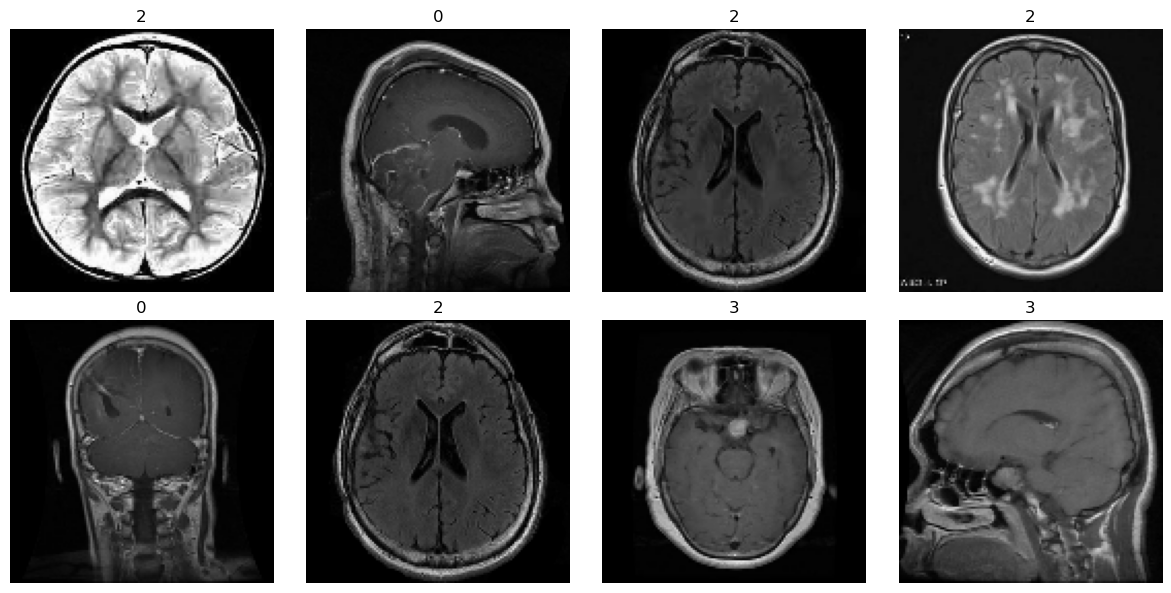

In [4]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

In [6]:
for images, labels in train_ds.take(1):
  shape = images.shape

2025-03-10 20:49:37.929280: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
shape


TensorShape([32, 128, 128, 3])

In [ ]:
INPUT_SHAPE = shape[1:]

Baseline CNN:

In [ ]:
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Add a Dropout layer with a 25% rate

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Add another Dropout layer

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))  # Add a Dropout layer before the dense layer

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Add a Dropout layer before the output layer
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model = create_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
history = model.fit(train_ds, epochs=50, validation_data = val_ds, callbacks=[early_stopping_cb])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.4334 - loss: 104.3227 - val_accuracy: 0.6576 - val_loss: 0.9127
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.6190 - loss: 0.9443 - val_accuracy: 0.7364 - val_loss: 0.8071
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6953 - loss: 0.7797 - val_accuracy: 0.7995 - val_loss: 0.6007
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7524 - loss: 0.6334 - val_accuracy: 0.8249 - val_loss: 0.5451
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7899 - loss: 0.5658 - val_accuracy: 0.8389 - val_loss: 0.4933
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8113 - loss: 0.4940 - val_accuracy: 0.8415 - val_loss: 0.4857
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8167 - loss: 0.4708 - val_accuracy: 0.8441 - val_loss: 0.4463
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8326 - loss: 0.4588 - val_accuracy:

In [ ]:
test_labels, predictions = eval_model_on_test(model)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:15,  1.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:03,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:02<00:02,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:02<00:02,  2.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:02<00:01,  3.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:02<00:00,  4.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  5.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:03<00:00,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


In [ ]:
pred_labels = np.argmax(predictions, axis=1)

In [ ]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
print(classification_report(test_labels, pred_labels, target_names=classes))


              precision    recall  f1-score   support

      glioma       0.89      0.88      0.89       300
  meningioma       0.88      0.82      0.85       306
     notumor       0.95      1.00      0.98       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.93      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



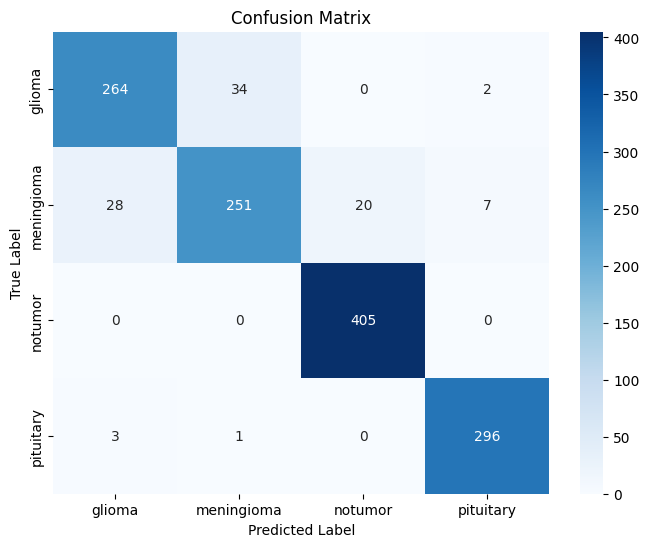

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Define class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Image Augmentation

In [ ]:
train_ds_aug = (train_ds.map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.2), label))
                        .map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                        .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))


In [ ]:
val_ds_aug = (val_ds.map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.2),label))
                    .map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                    .shuffle(2000)
                    .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
model = create_model()
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
history = model.fit(train_ds_aug, epochs=100, validation_data = val_ds_aug, callbacks=[early_stopping_cb])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.3758 - loss: 37.7215 - val_accuracy: 0.6313 - val_loss: 1.0505
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.5015 - loss: 1.1729 - val_accuracy: 0.6278 - val_loss: 0.9630
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.5427 - loss: 1.0882 - val_accuracy: 0.6585 - val_loss: 0.9312
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.5989 - loss: 0.9899 - val_accuracy: 0.7294 - val_loss: 0.7868
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.6166 - loss: 0.9492 - val_accuracy: 0.7574 - val_loss: 0.6532
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 105ms/step - accuracy: 0.6808 - loss: 0.7999 - val_accuracy: 0.7172 - val_loss: 0.7171
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.6980 - loss: 0.7278 - val_accuracy: 0.7828 - val_loss: 0.6043
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7416 - loss: 0.65

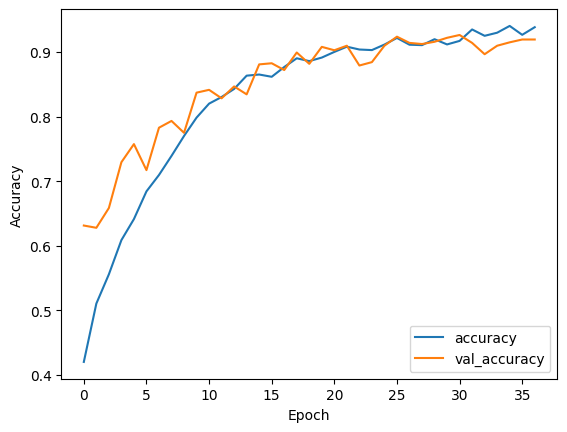

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

In [ ]:
test_labels, predictions = eval_model_on_test(model)
pred_labels = np.argmax(predictions, axis=1)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
print(classification_report(test_labels, pred_labels, target_names=classes))

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:02<00:27,  2.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:03<00:11,  1.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:03<00:06,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:03<00:04,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:03<00:02,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Predicting on Test Data:  55%|█████▍    | 6/11 [00:03<00:01,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:04<00:01,  3.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Predicting on Test Data:  73%|███████▎  | 8/11 [00:04<00:00,  4.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Predicting on Test Data:  82%|████████▏ | 9/11 [00:04<00:00,  4.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:04<00:00,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]

              precision    recall  f1-score   support

      glioma       0.97      0.84      0.90       300
  meningioma       0.85      0.90      0.87       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.95      1.00      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Define class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Trying VGG model

In [ ]:
# Load a new instance of the VGG19 model.
model = tf.keras.applications.VGG19(
    input_shape=(128,128,3),
    include_top=False,
    weights='imagenet')

# Points to the last layer to ignore the top layer.
last_conv_layer = model.get_layer('block5_conv4')  # Last convolutional layer of VGG19

conv_model = Model(inputs=model.input,
                   outputs=last_conv_layer.output)

# Start a new Keras Sequential model.
model_vgg = Sequential()

# Add the convolutional part of the model from above.
model_vgg.add(conv_model)

# Add a global average pooling layer.
model_vgg.add(tf.keras.layers.GlobalAveragePooling2D())
model_vgg.add(layers.Dropout(0.4))  # Add a Dropout layer before the output layer

# Add a final dense layer for predictions.
model_vgg.add(tf.keras.layers.Dense(4, activation='softmax'))

# Compile the model (don't forget this step)
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now you can proceed with data preparation and training the model

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
pretrained.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_5 (Functional)            │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           8,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)
loss = 'sparse_categorical_crossentropy'
lst_metrics = ['sparse_categorical_accuracy']

In [ ]:
# Initially freeze all layers
for layer in conv_model.layers:
    layer.trainable = False


In [ ]:
def print_layer_trainable(model_name):
    """prints out layer names and if they are trainable or not of a given model"""

    print('trainable : layer name')
    print('- '*30)
    for layer in model_name.layers:
      # if layer.trainable:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

    return

In [ ]:
print_layer_trainable(conv_model)

trainable : layer name
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
False:	input_layer
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_conv4


In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')
callbacks = [ES,RL]


In [ ]:
model_vgg.compile(optimizer=optimizer, loss=loss, metrics=lst_metrics)
epochs = 50

history = model_vgg.fit(train_ds_aug,
                        epochs=epochs,
                        validation_data=val_ds_aug,
                        callbacks = callbacks
                        )

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 268ms/step - loss: 1.8829 - sparse_categorical_accuracy: 0.4093 - val_loss: 1.0729 - val_sparse_categorical_accuracy: 0.5788 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 261ms/step - loss: 1.6153 - sparse_categorical_accuracy: 0.4502 - val_loss: 1.0320 - val_sparse_categorical_accuracy: 0.6138 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 617ms/step - loss: 1.4628 - sparse_categorical_accuracy: 0.4946 - val_loss: 0.9417 - val_sparse_categorical_accuracy: 0.6419 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 263ms/step - loss: 1.3544 - sparse_categorical_accuracy: 0.5322 - val_loss: 0.8871 - val_sparse_categorical_accuracy: 0.6778 - learning_rate: 1.0000e-04
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 270ms/step - loss: 1.2784 - sparse_categorical_accuracy: 0.5630 - val_loss: 0.8530 - val_sparse_categorical_accuracy: 0.6979 - learning_rate: 1.0000e-04
Epoch 6/50
143/

Try and open up VGG layers for training:

In [ ]:
# Load a new instance of the VGG19 model.
model = tf.keras.applications.VGG19(
    input_shape=(128,128,3),
    include_top=False,
    weights='imagenet')

# Points to the last layer to ignore the top layer.
last_conv_layer = model.get_layer('block5_conv4')  # Last convolutional layer of VGG19

conv_model = Model(inputs=model.input,
                   outputs=last_conv_layer.output)

# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the model from above.
new_model.add(conv_model)

# Add a global average pooling layer.
new_model.add(tf.keras.layers.GlobalAveragePooling2D())
new_model.add(layers.Dropout(0.4))  # Add a Dropout layer before the output layer

# Add a final dense layer for predictions.
new_model.add(tf.keras.layers.Dense(4, activation='softmax'))

# Compile the model (don't forget this step)
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now you can proceed with data preparation and training the model

In [ ]:
conv_model.summary()

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initially freeze all layers
for layer in conv_model.layers:
    layer.trainable = False

# Unfreeze layers containing 'conv5' but skip those containing 'bn'
for layer in conv_model.layers:
    if 'block5' in layer.name and 'bn' not in layer.name:
        layer.trainable = True

In [ ]:
print_layer_trainable(conv_model)

trainable : layer name
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
False:	input_layer_25
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_conv4


In [ ]:
optimizer = Adam(learning_rate=1e-4)
loss = 'sparse_categorical_crossentropy'
lst_metrics = ['sparse_categorical_accuracy']

In [ ]:
model_vgg.compile(optimizer=optimizer, loss=loss, metrics=lst_metrics)
epochs = 50

history = new_model.fit(train_ds_aug,
                        epochs=epochs,
                        validation_data=val_ds_aug,
                        callbacks = callbacks
                        )

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 1.3839 - sparse_categorical_accuracy: 0.4159 - val_loss: 0.5899 - val_sparse_categorical_accuracy: 0.7898 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.5767 - sparse_categorical_accuracy: 0.7917 - val_loss: 0.3592 - val_sparse_categorical_accuracy: 0.8774 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.3202 - sparse_categorical_accuracy: 0.8853 - val_loss: 0.2338 - val_sparse_categorical_accuracy: 0.9177 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.2037 - sparse_categorical_accuracy: 0.9338 - val_loss: 0.2741 - val_sparse_categorical_accuracy: 0.9098 - learning_rate: 1.0000e-04
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.1573 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.3186 - val_sparse_categorical_accuracy: 0.9002 - learning_rate: 1.0000e-04
Epoch 6/50
143/143 ━━━━

In [ ]:
test_labels, predictions = eval_model_on_test(model_vgg)
pred_labels = np.argmax(predictions, axis=1)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
print(classification_report(test_labels, pred_labels, target_names=classes))

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:01,  4.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Predicting on Test Data: 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]

              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       300
  meningioma       0.98      0.94      0.96       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



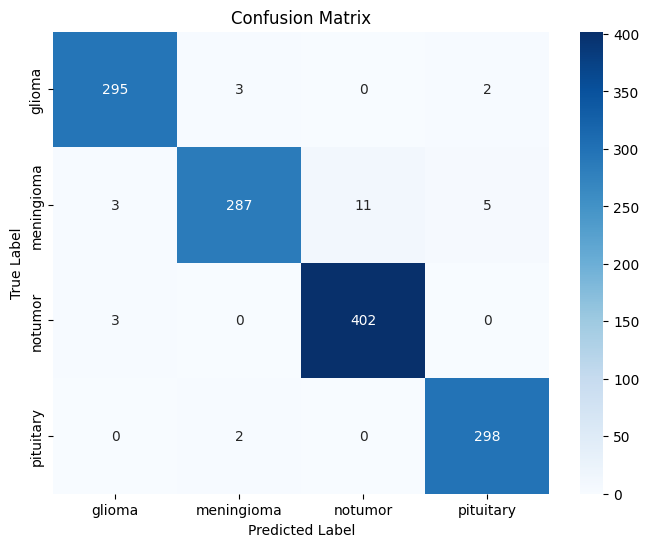

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Define class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()